# <center>CSE 4/546: Reinforcement Learning</center>
## <center>Prof. Alina Vereshchaka</center>
### <center>Assignment 1, Part 3</center>

In [35]:
# Imports
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import pickle
from collections import defaultdict
import sys
import os
import copy

### Stock Trading Environment 

In [36]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

         info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [37]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'. To train the agent, set 'train=True', and to evaluate the agent, set 'train=False'.

stock_trading_environment = StockTradingEnvironment(file_path='./NVDA.csv', train=True, number_of_days_to_consider=10)

### TO DO: Implement the Q-learning algorithm

In [38]:
# -----------------------------------------------------
#   Q-Learning For Stock Market 
# -----------------------------------------------------

def default_q():
    """
    I define a default Q-function for any new state encountered.
    The environment has 3 possible actions: 0 (Buy), 1 (Sell), 2 (Hold).
    Therefore, I return an array of length 3 initialized to zeros.
    """
    return np.zeros(3)
def train_stock_Q(env, hyperparams):
    """
    I train a Q-learning agent on the StockTradingEnvironment.
    
    :param env: The StockTradingEnvironment instance (train=True).
    :param hyperparams: Dictionary of hyperparameters.
    
    :return: (Q, rewards_per_episode, eps_history)
        Q: A defaultdict mapping state -> Q-values (array of length 3).
        rewards_per_episode: List of cumulative rewards per episode.
        eps_history: List of epsilon values per episode.
    """

    # -- I read the hyperparameters --
    alpha = hyperparams.get('alpha', 0.1)          # Learning rate
    gamma = hyperparams.get('gamma', 0.95)           # Discount factor
    epsilon = hyperparams.get('epsilon', 1.0)        # Initial exploration rate
    epsilon_decay = hyperparams.get('epsilon_decay', 0.995)  # Epsilon decay rate
    epsilon_min = hyperparams.get('epsilon_min', 0.01)       # Minimum epsilon value
    episodes = hyperparams.get('episodes', 200)      # Number of training episodes

    # -- I create a Q-table as a defaultdict --
    Q = defaultdict(default_q)

    # -- I initialize lists to store stats --
    rewards_per_episode = []
    eps_history = []

    # -- I set up variables to track the best Q-table --
    best_reward = -np.inf
    best_q_table_filename = "part_3_files/part_3_q_table.pkl"

    # -- I run the Q-learning loop for the specified number of episodes --
    for ep in range(episodes):
        # I reset the environment to start a new episode
        state, info = env.reset()
        
        # At the start, I'm not done or truncated
        done = False
        truncated = False
        total_reward = 0
        
        print(f"\n--- Training Episode {ep+1} starting ---")

        step_count = 0

        # I continue until the environment signals termination
        while not done and not truncated:
            # Possible actions in the stock environment are [0, 1, 2] = [Buy, Sell, Hold]
            safe_actions = [0, 1, 2]

            # I pick an action using epsilon-greedy
            if random.random() < epsilon:
                # I explore with a random action
                action = random.choice(safe_actions)
            else:
                # I exploit the best known action from the Q-table
                q_vals = Q[state]  # Q-values for the current state (array of length 3)
                action = np.argmax(q_vals)

            # I take the chosen action in the environment
            next_state, reward, done, truncated, info = env.step(action)
            
            # I accumulate the reward
            total_reward += reward

            # I update the Q-value using the Q-learning formula
            best_next = np.max(Q[next_state])  # best Q-value for next_state
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            # I move on to the next state
            state = next_state
            
            # I display interim info
            step_count += 1
            # (Optional) print(f"Step {step_count} - Cumulative Reward: {total_reward}")

        # After this episode finishes, I decay epsilon for the next episode
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        # I store stats for later analysis
        rewards_per_episode.append(total_reward)
        eps_history.append(epsilon)

        # I log episode summary
        print(f"Episode {ep+1}/{episodes} | Steps: {step_count} | Total Reward: {total_reward} | Epsilon: {epsilon:.3f}")

        # I update the saved best Q-table only if this episode's total reward beats the best so far
        if total_reward > best_reward:
            best_reward = total_reward
            best_Q = copy.deepcopy(Q)
            with open(best_q_table_filename, "wb") as pf:
                pickle.dump(best_Q, pf)
            print(f"New best Q-table saved with reward: {best_reward:.3f}")
        else:
            print(f"Episode reward {total_reward:.3f} did not beat best reward {best_reward:.3f}")

    return Q, rewards_per_episode, eps_history


def evaluate_stock_Q(env, q_table_filename="part_3_files/part_3_q_table.pkl",
                     episodes=10):
    """
    I evaluate a trained Q-learning agent on the StockTradingEnvironment in 'test' mode.
    
    :param env: The StockTradingEnvironment instance (train=False).
    :param q_table_filename: Path to the saved Q-table pickle file.
    :param episodes: Number of evaluation episodes.
    :return: rewards, a list of total rewards per episode.
    """

    # I load the Q-table
    with open(q_table_filename, "rb") as pf:
        Q = pickle.load(pf)

    rewards = []

    # I run multiple episodes for evaluation
    for ep in range(episodes):
        # I reset and get the initial state
        state, info = env.reset()
        done = False
        truncated = False
        total_reward = 0

        # I continue until the environment signals termination
        while not done and not truncated:
            # I pick the best known action from the Q-table
            action = np.argmax(Q[state])
            # Step in the environment
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            # Move to next state
            state = next_state

        # Episode finished
        rewards.append(total_reward)
        env.render()
        print(f"Evaluation Episode {ep+1}/{episodes} | Total Reward: {total_reward}")

    return rewards

In [39]:
stock_trading_environment = StockTradingEnvironment(file_path='./NVDA.csv', train=True, number_of_days_to_consider=10)

In [40]:
hyperparams = {   
    'alpha': 0.005,
    'gamma': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.9995,
    'epsilon_min': 0.01,
    'episodes': 10000,
}

Q, rewards_per_episode, eps_history = train_stock_Q(stock_trading_environment, hyperparams=hyperparams)


--- Training Episode 1 starting ---
Episode 1/10000 | Steps: 408 | Total Reward: -1138.6196516967636 | Epsilon: 1.000
New best Q-table saved with reward: -1138.620

--- Training Episode 2 starting ---
Episode 2/10000 | Steps: 408 | Total Reward: -954.6080502884979 | Epsilon: 0.999
New best Q-table saved with reward: -954.608

--- Training Episode 3 starting ---
Episode 3/10000 | Steps: 408 | Total Reward: -1136.2194049484046 | Epsilon: 0.999
Episode reward -1136.219 did not beat best reward -954.608

--- Training Episode 4 starting ---
Episode 4/10000 | Steps: 408 | Total Reward: -1091.3766035410185 | Epsilon: 0.998
Episode reward -1091.377 did not beat best reward -954.608

--- Training Episode 5 starting ---
Episode 5/10000 | Steps: 408 | Total Reward: -1186.3165176901214 | Epsilon: 0.998
Episode reward -1186.317 did not beat best reward -954.608

--- Training Episode 6 starting ---
Episode 6/10000 | Steps: 408 | Total Reward: -1269.3419368942045 | Epsilon: 0.997
Episode reward -126

In [41]:
stock_trading_environment = StockTradingEnvironment(file_path='./NVDA.csv', train=True, number_of_days_to_consider=2)

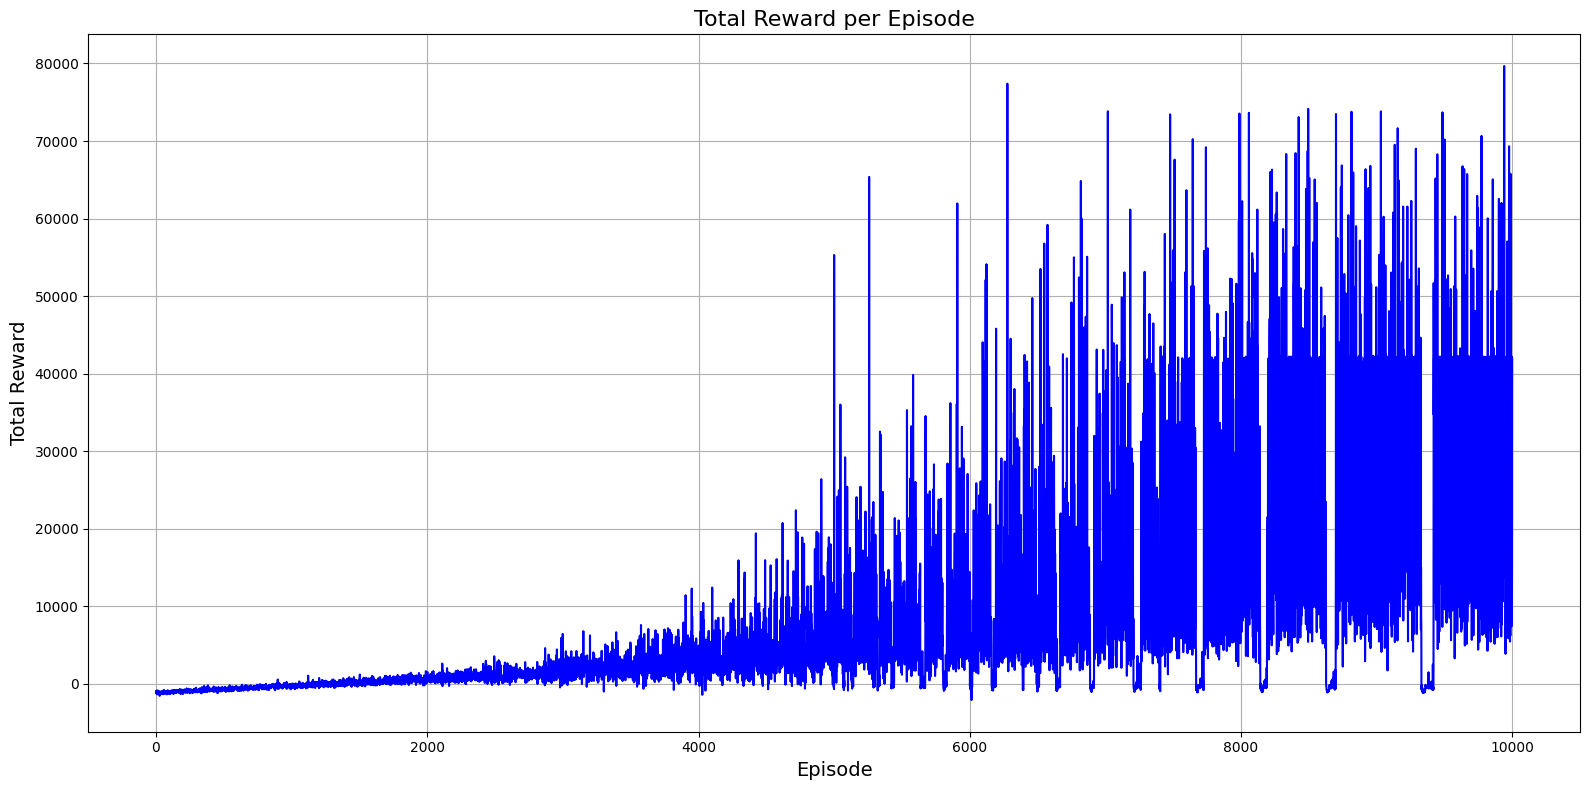

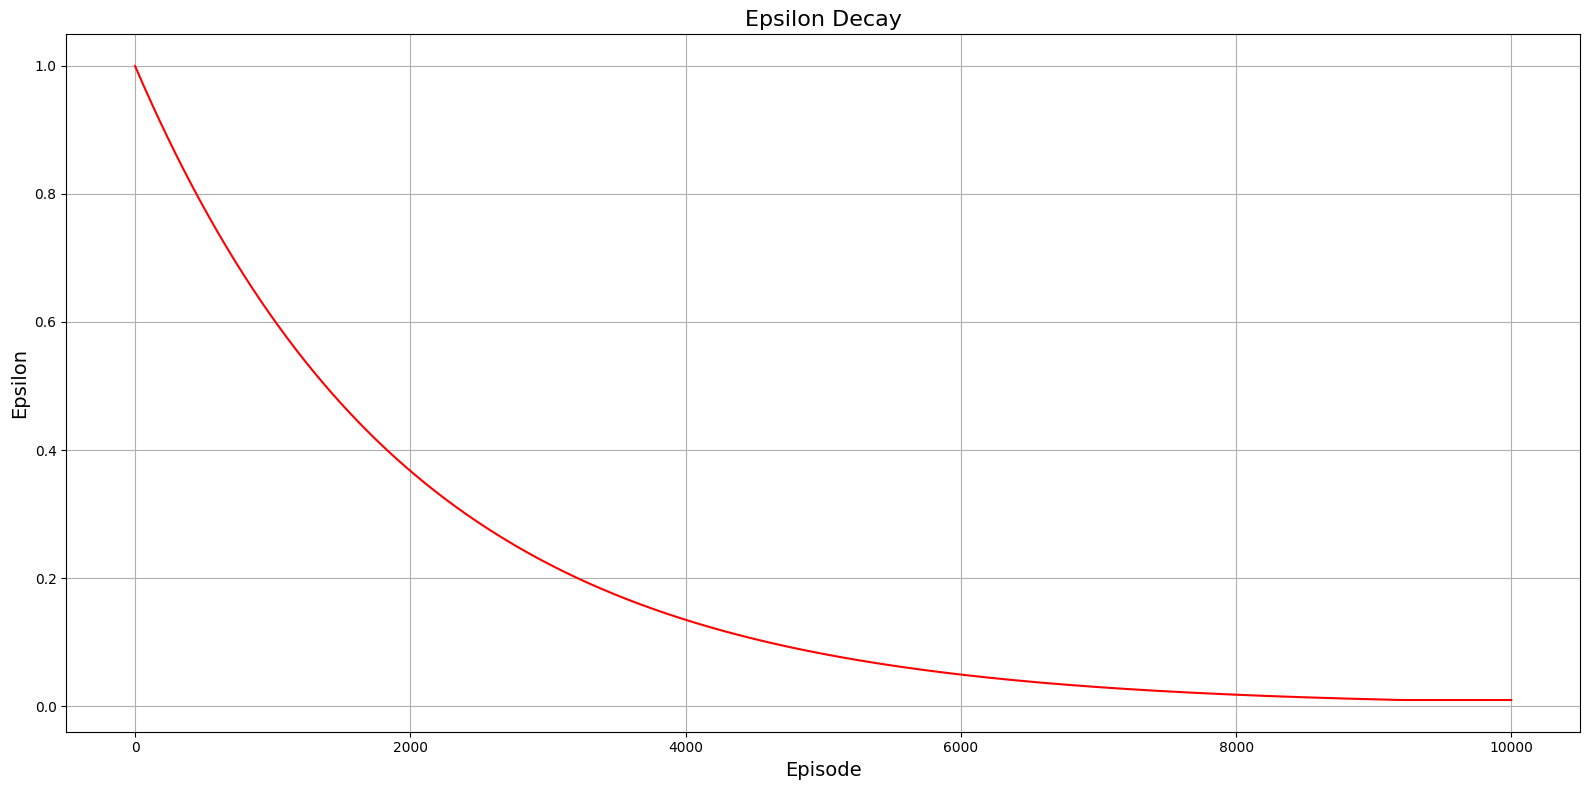

In [42]:
# Plotting total reward per episode
plt.figure(figsize=(16,8))
plt.plot(rewards_per_episode, color='blue', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Total Reward per Episode", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting epsilon decay over episodes
plt.figure(figsize=(16,8))
plt.plot(eps_history, color='red', linewidth=1.5)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Epsilon", fontsize=14)
plt.title("Epsilon Decay", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
"""
Printing initial Q-tables, which are empty since I am using a dictionary for easier implementation. 
I am commenting out this entire block because the Q-values/tables are very large. 
The trained Q-table has been saved in this folder. 

To print the saved Q-values/tables, simply uncomment the code below and run it.
"""

q_table_filename = "part_3_files/part_3_q_table.pkl"

print("\nInitial Q-table (empty entries as I am using a dictionary for easier implementation):")

Q = defaultdict(default_q)
for k, v in Q.items():
    print(k, v)

# Loading the Q-table from the pickle file
with open(q_table_filename, "rb") as pf:
    Q = pickle.load(pf)

# Printing the final Q-table
print("\nTrained Q-table (for visited states):\n")
for k, v in Q.items():
    print(k, v)


Initial Q-table (empty entries as I am using a dictionary for easier implementation):

Trained Q-table (for visited states):

0 [1302.99924443  383.73171147  372.08989362]
1 [1176.98695943 1172.48736257 1740.30077686]
2 [965.73580584 341.18676392 359.96181981]
3 [ 998.73571359  728.23741122 1471.30100796]


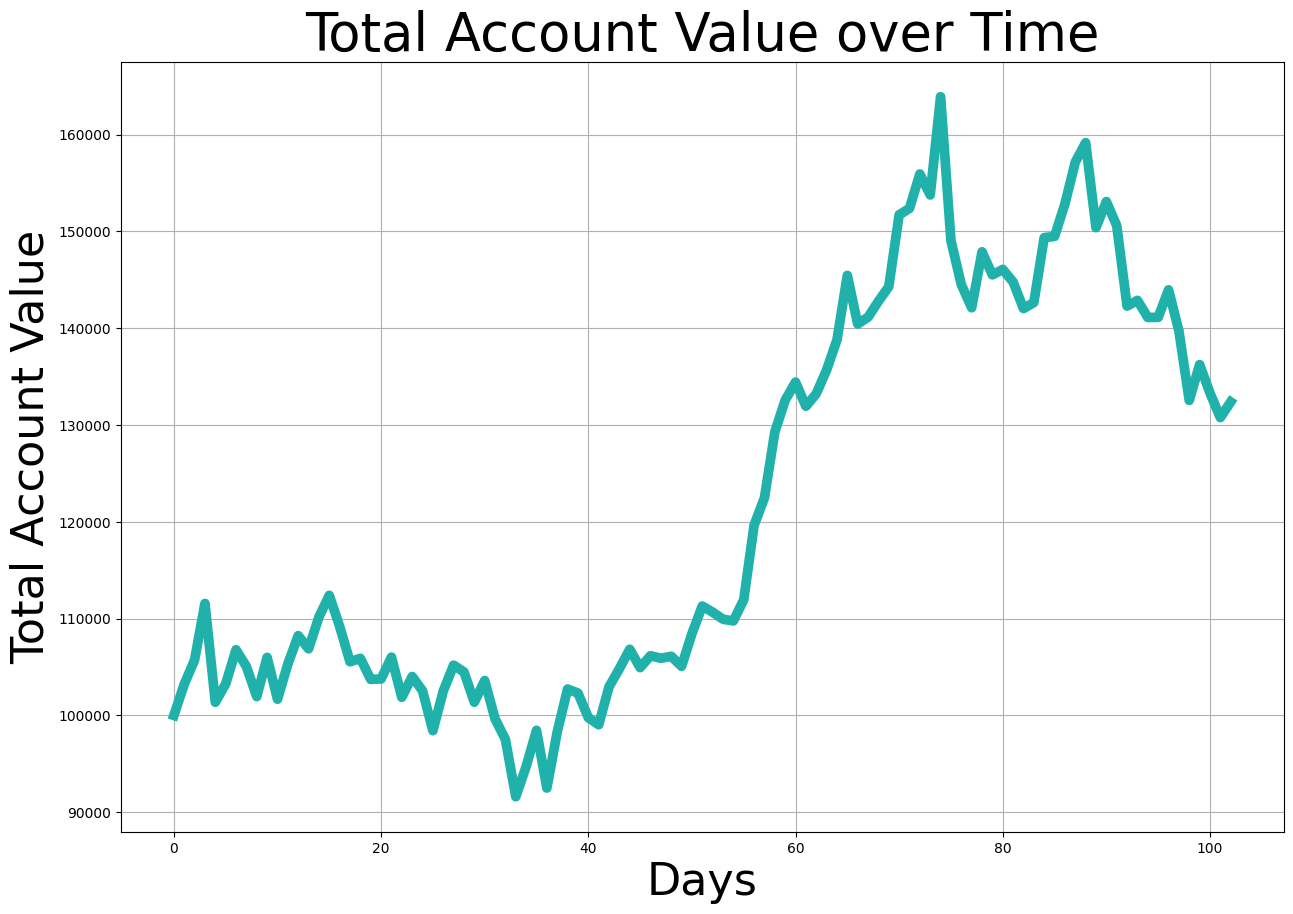

Evaluation Episode 1/2 | Total Reward: 2244.293488095232


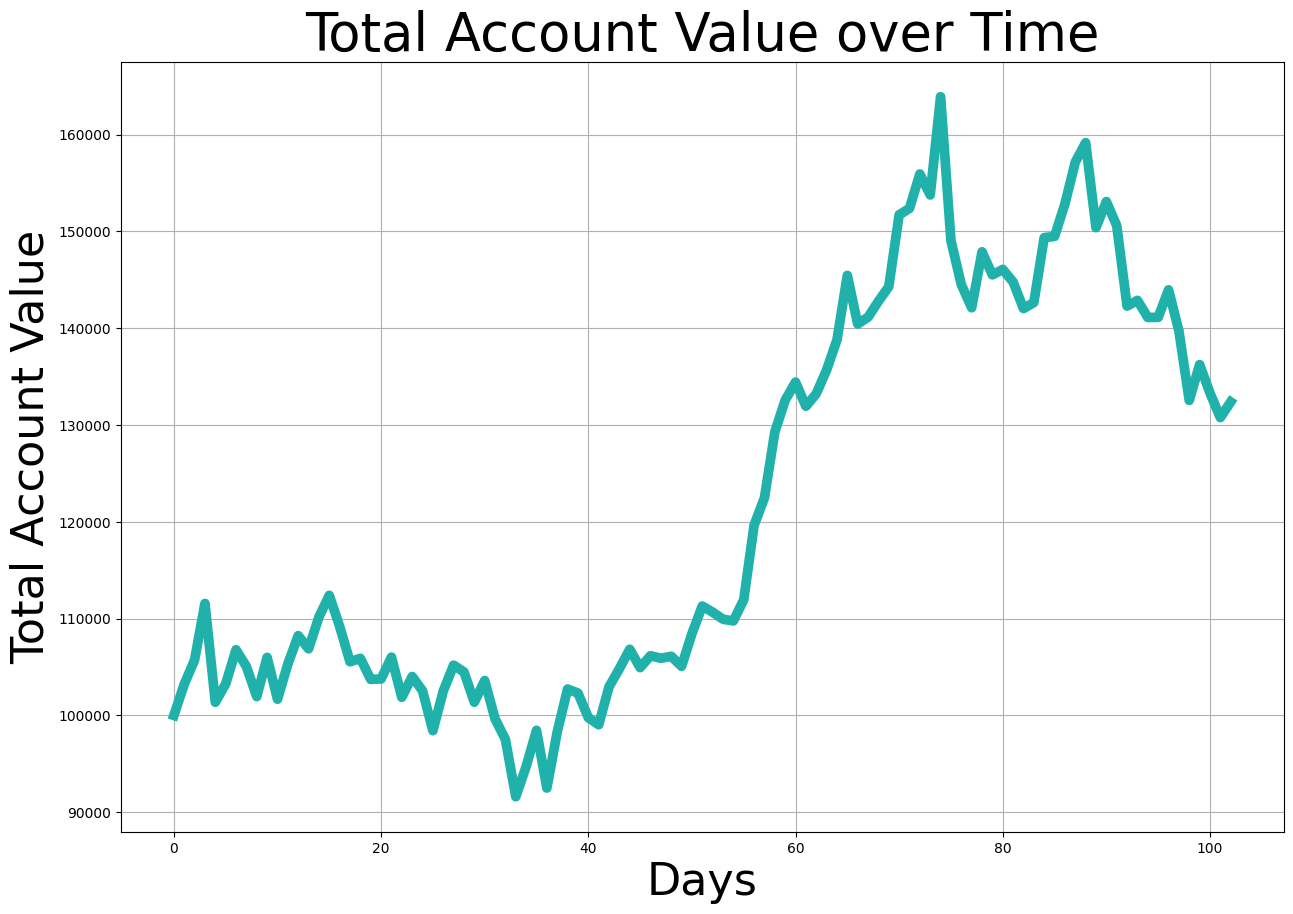

Evaluation Episode 2/2 | Total Reward: 2244.293488095232


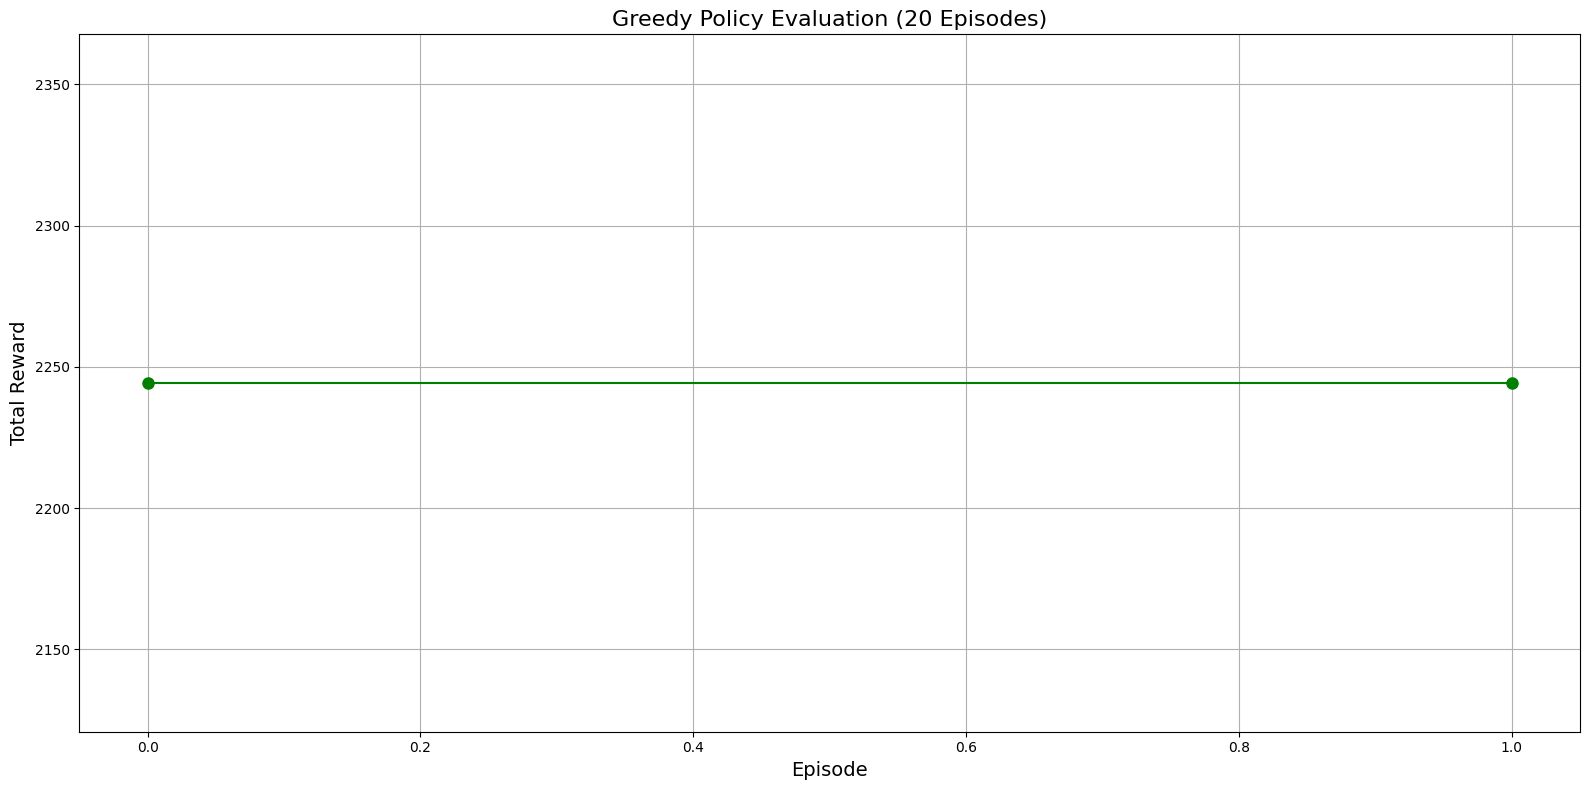

In [44]:
# Loading the trained Q-table
q_table_filename = "part_3_files/part_3_q_table.pkl"

prod_stock_trading_environment = StockTradingEnvironment(file_path='./NVDA.csv', train=False, number_of_days_to_consider=2)

rewards = evaluate_stock_Q(prod_stock_trading_environment, q_table_filename=q_table_filename, episodes= 2)

# Plotting greedy policy evaluation
plt.figure(figsize=(16,8))
plt.plot(rewards, marker='o', linestyle='-', color='green', markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Greedy Policy Evaluation (20 Episodes)", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()